# ANDA-NI Virtual Neuroinformatics Course
# Introduction to NIX: A Versatile Data File Format for Metadata and Measurements

<img src="resources/D1S3/nix_logo.png" alt="Nix Logo" width="200"/>

||                                                                                |
|--:|--------------------------------------------------------------------------------|
|Homepage| [http://g-node.github.io/nix](http://g-node.github.io/nix)                   |
|GitHub| [https://github.com/G-Node/nixpy](https://github.com/G-Node/nixpy)             |
|Documentation| [https://nixpy.readthedocs.io/en/latest](https://nixpy.readthedocs.io/en/latest) |
|Bug reports| [https://github.com/G-Node/nixpy/issues](https://github.com/G-Node/nix/issues) |
|Python Package Index (PyPI)| [https://pypi.org/project/nixpy/](https://pypi.org/project/nixpy/)             |

Welcome to this comprehensive tutorial on NIX, a data file format developed by the German Neuroinformatics Node (G-Node). Whether you are a researcher, data scientist, or developer working with scientific data, understanding the NIX format can significantly enhance your workflow by providing a common basis for storing and sharing complex data sets.

## What is NIX?

NIX (Neuroscience Information Exchange) is an open file format designed to store and organize complex scientific data. It aims to provide a standardized way to store experimental data, metadata, and related information in a consistent, easily accessible, and reproducible manner.

**Key Features:**

- **Hierarchical Structure:** NIX supports a hierarchical data model that allows you to organize data and metadata in a logical and intuitive way.
- **Self-Describing Files:** Each NIX file contains not just raw data, but also comprehensive metadata that describes the data's context, making it easier to understand and reuse.
- **Interoperability:** By adhering to a common standard, NIX files can be easily shared and understood across different software and research groups.

## Why Use NIX?

Research often involves dealing with diverse and complex data sets that need to be organized and annotated in a standardized fashion. Traditional file formats may lack the capability to store rich metadata or enforce consistency. NIX addresses these issues by providing a flexible and robust structure to hold various types of data and their associated metadata.

Using NIX can help in:
- **Ensuring Data Integrity:** With NIX's rigorous structuring and metadata support, your data retains its meaning and integrity over time.
- **Facilitating Reproducibility:** By embedding descriptive metadata, NIX files make it easier to reproduce experiments and analyses.
- **Enhancing Collaboration:** Standardized data formats foster better collaboration, as data shared among different groups maintain a consistent structure.
  
## Who is This Tutorial For?

This tutorial is designed for:
- **Researchers** who need to store experimental data in a structured and accessible manner.
- **Data Scientists** looking for standardized ways to manage complex data sets and metadata.
- **Software Developers** who are building applications that involve scientific data management and need a reliable file format.

## Prerequisites

Before starting this tutorial, it is recommended that you have:
- Basic understanding of scientific research data.
- Familiarity with concepts of data organization and metadata.
- Basic programming knowledge, preferably in Python, as we will use Python to interact with NIX files.

In this tutorial, we will cover the fundamental aspects of the NIX data file format to more advanced features. By the end, you should be able to efficiently store, manage, and share your scientific data using NIX.

Let's begin our journey into the NIX data file format and explore its capabilities!

# Basics

This section covers the basics of working with nix files.

1. Opening and closing nix files with different file ``FileModes``.
2. Storing data and using dimension descriptors.

## Working with files

In [2]:
import nixio
print("nixio library version:", nixio.__version__)

nixio library version: 1.5.3


### Create a new file

* The following command tries to open the file "new_data_file.nix" in ``nix.FileMode.ReadWrite`` mode.
* If it does not exist, it will be created.

In [3]:
nixfile = nixio.File.open("new_data_file.nix", nixio.FileMode.ReadWrite)
print("file format:", nixfile.format)
print("nix data model version:", nixfile.version)

file format: nix
nix data model version: (1, 2, 1)


### nixio writes hdf5 files

* The file is an HDF5 file, the standard file extension would be ``*.h5``
* The file extension can be anything you wish.
* We will always use ``*.nix`` to indicate how it should be opened.

Files can be opened in different ``FileModes``, nixio defines three different modes:

1. ``nixio.FileMode.ReadWrite`` the default mode
2. ``nixio.FileMode.ReadOnly``
3. ``nixio.FileMode.Overwrite``

An opened file should be closed after you are done with it to finish any pending write and free any resources used by h5py.

In [4]:
nixfile.close()

The written file is an [HDF5](https://www.hdfgroup.org/) file, we can use the tools that are provided by the HDF5 library to access the file.

In [5]:
!h5ls -v new_data_file.nix

'h5ls' is not recognized as an internal or external command,
operable program or batch file.


# Storing data in a NIX file

The main purpose of a nix file is to store data, e.g. when recording the membrane or field potential data. 
Usually, these data are read as floats representing the potential and are sampled at evenly spaced times at a given *sampling rate*.

![data model](resources/D1S3/nix_regular_sampled.png)

We need to store:
- the data (voltage measurements)
- the y-axis labeling, i.e. label (voltage) and unit (mV)
- the x-axis labeling, i.e. label (time) and unit (s)
- the x-position for each data point
- a title/legend


## The DataArray

**DataArrays** store the data. They live inside a **Block** entity that is a top-level grouping element.

But, it only stores the y-values!

The x-positions are defined by a **Dimension** descriptor. In this case this descriptor stores:

- a definition of the x-axis consisting of an offset
- the sampling interval
- a label
- and a (physical) unit.


In [6]:
import nixio
import numpy as np

dt = 0.001
duration = 10.0
time = np.arange(0.0, duration, dt)
voltage_data = np.sin(2 * np.pi * time * 0.5)

nixfile = nixio.File.open("regularly_sampled_data.nix", nixio.FileMode.Overwrite)
block = nixfile.create_block("session 1", "nix.session")
array = block.create_data_array("sinewave", "nix.data.sampled", data=voltage_data, label="voltage", unit="Hz")
array.append_sampled_dimension(dt, label="time", unit="s")

nixfile.close()


## Reading Data from a DataArray

Storing is one thing, reading out the information is the obvious next step...


In [7]:
nixfile = nixio.File.open("regularly_sampled_data.nix", nixio.FileMode.ReadOnly)
block = nixfile.blocks["session 1"]
array = block.data_arrays["sinewave"]
print(array)


DataArray: {name = sinewave, type = nix.data.sampled}


Cool, now we found the **DataArray** that contains the data. What to do with it? Let's find out some of it's properties.

In [8]:
print("Name, id, and type", array.name, array.id, array.type)
print("Data extent (aka shape), and data type:", array.data_extent, array.dtype)
print("Label and unit of the data:", array.label, array.unit)
import sys
print("DataArray size in memory:", sys.getsizeof(array), "bytes")

Name, id, and type sinewave dfee15fc-3292-4653-b706-fb583a972dc7 nix.data.sampled
Data extent (aka shape), and data type: (10000,) float64
Label and unit of the data: voltage Hz
DataArray size in memory: 48 bytes


The *array* object we read from file is small. It can not possibly contain 10000 double values and all the other information.

**Note:** nixio objects are lightweight objects that are basically pointers to the location in the file!
Every time we read information from it, it is a read access to the file. This makes them cheap to create and maintain in memory but reading information takes a little.

So, how to read the data itself? We need to access it and can use numpy style to do so.

In [9]:
sinewave_data = array[:]
print(type(sinewave_data), sinewave_data.shape)

partial_sinewave_data = array[::10]
print(type(partial_sinewave_data), partial_sinewave_data.shape)

<class 'numpy.ndarray'> (10000,)
<class 'numpy.ndarray'> (1000,)


In [10]:
%config InlineBackend.figure_formats = ['retina'] # only for users with a high resolution display
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(sinewave_data, label="original")
plt.plot(partial_sinewave_data, label="subsampled")
plt.legend()





It is a plot -- but some parts are missing. All this information is stored in the **DataArray**.

Let's start with the y-labeling: This information is stored in the **DataArray** itself.


In [11]:
plt.plot(sinewave_data, label="original")
plt.plot(partial_sinewave_data, label="subsampled")
plt.legend()
plt.ylabel("%s [%s]" % (array.label, array.unit))

Text(22.097222222222214, 0.5, 'voltage [Hz]')

What about the x-labeling? To fix this we need to get the dimension descriptor for the time-dimension.

In [12]:
time_dimension = array.dimensions[0]

plt.plot(sinewave_data, label="original")
plt.plot(partial_sinewave_data, label="subsampled")
plt.legend()
plt.ylabel("%s [%s]" % (array.label, array.unit))
plt.xlabel("%s [%s]" % (time_dimension.label, time_dimension.unit))

Text(0.5, 23.52222222222222, 'time [s]')

So far so good. But something's still off, let's fix this:

We need to use further information from the dimension descriptor (the sampling interval, and the offset) to create it with numpy, or we ask the dimension descriptor to do it for us.

In [13]:

time_dimension = array.dimensions[0]
sinewave_time_axis = time_dimension.axis(len(sinewave_data))
partial_sinewave_time_axis = sinewave_time_axis[::10]

plt.plot(sinewave_time_axis, sinewave_data, label="original")
plt.plot(partial_sinewave_time_axis, partial_sinewave_data, label="subsampled")
plt.legend()
plt.ylabel("%s [%s]" % (array.label, array.unit))
plt.xlabel("%s [%s]" % (time_dimension.label, time_dimension.unit))

Text(0.5, 23.52222222222222, 'time [s]')

**Done!** As you see, nix allows you to save the data object in its entirety and with a complete description.

## Irregularly sampled data

What about data that is not regularly sampled (in time)?

![data model](resources/D1S3/nix_irregular_sampled.png)

A signal similar to what we had before is recorded but this time the temporal distance between the measurements is not regular. Storing this kind of data is not as efficient as in the regularly sampled case since we need to store the time of each measurement and the measured value. The following information needs to be stored to describe the dimension:

1. x-positions of the data points, i.e. ticks
2. label
3. unit

In this kind of dimension we store a range of ticks, therefore the name **RangeDimension**. It needs to be added to the **DataArray** when it is created.

### Radar trap example scenario

Let's consider a scenario in which information does not flow in in a steady stream but comes in irregularly such as a radar trap. With each passing car there will be a measurement but the intervals at which the measurements are taken are defined by the traffic, not the measurement system.


In [14]:
import numpy as np

def radar_trap_data(duration=1000, car_probability=0.15, dt=0.01, speed_limit=50, speeder_probability=0.01):
    time = np.arange(0, duration, dt)
    car_times = time[np.random.random(len(time)) < (car_probability * dt)]
    car_speeds = speed_limit + np.random.randn(len(car_times)) * 0.05 * speed_limit
    indices = np.arange(len(car_times), dtype=int)
    np.random.shuffle(indices)
    speeders = indices[:int(np.round(speeder_probability * len(car_times)))]
    car_speeds[speeders] += 0.5 * speed_limit
    return car_times, car_speeds


times, speeds = radar_trap_data()

plt.plot(times, speeds, marker=".", zorder=2)
plt.hlines([50], 0, times[-1], color="grey", ls="--", zorder=1)

In [15]:
nixfile = nixio.File.open("radar_trap.nix", nixio.FileMode.Overwrite)
block = nixfile.create_block("radar trap", "speed measurements")

data_array = block.create_data_array("car speeds", "nix.irregular_sampled", data=speeds, label="speed", unit="km/h")
data_array.append_range_dimension(ticks=times, unit="s", label="time")

nixfile.close()

### Spike times

Sometimes the times of certain events (e.g. action potentials in neurophysiology) is the the data and the dimension at the same time.

Since the data is still irregularly sampled, we use a **RangeDimension** to describe the time axis but we tell it to use the "parent" **DataArray** as a source for the ticks.

```
spike_times = get_spike_times(data)

spikes_data_array = block.create_data_array("spike times", "nix.irregular_sampled.spike_times", data=spike_times, label="time", unit="s")
spikes_data_array.append_range_dimension_using_self()
```

## Categorical data

![data model](resources/D1S3/nix_set_dimension.png)

If we need to store data that falls into categories, i.e. the x-positions are not numeric or the dimension does not have a natural order, a SetDimension is used. It stores a label for each entry along the described dimension.

In [16]:
def create_data():
    categories = ["Jan", "Feb", "Mar", "Apr", "May", "Jun"]
    temperatures = [100, 110, 95, 150, 200, 250]

    return temperatures, categories

temperatures, months = create_data()

nixfile = nixio.File.open("categorical_data.nix", nixio.FileMode.Overwrite)

block = nixfile.create_block("weather data", "test")
data_array = block.create_data_array("category data", "nix.categorical", data=temperatures, label="temperature", unit="K")
data_array.append_set_dimension(labels=months)

nixfile.close()

## 2-D data

**DataArrays** can store n-dimensional data. In such cases we need to provide n dimension descriptors.

![data model](resources/D1S3/multiple_channels.png)

The first dimension represents time, the second the channels. Since the data is regularly sampled the time dimension is fully described by a **SampledDimension**, the channel dimension is described by a **SetDimension** which contains the channel names.

In [17]:
def create_data(duration=10, num_channels=10, dt=0.0001):
    samples = int(duration / dt)
    data = np.zeros((samples, num_channels))
    time = np.arange(samples) * dt
    for i in range(num_channels):
        phase = i * 2 * np.pi / num_channels
        data[:, i] = np.sin(2 * np.pi * time + phase) + (np.random.randn(samples) * 0.1)

    return data


dt = 0.001
duration = 10
number_of_channels = 10
multichannel_data = create_data(duration, number_of_channels, dt)

nixfile = nixio.File.open("multichannel_data.nix", nixio.FileMode.Overwrite)
block = nixfile.create_block("Session 1", "nix.recording_session")

data_array = block.create_data_array("multichannel_data", "nix.sampled.multichannel", data=multichannel_data, label="voltage", unit="mV")
data_array.append_sampled_dimension(0.001, label="time", unit="s")
data_array.append_set_dimension(labels=["channel %i" % i for i in range(number_of_channels)])

nixfile.close()

# Tagging

Tagging is the mechanism by which we can annotate points or regions in recorded data.

![data model](resources/D1S3/tag1.png)

For example, at some point a stimulus is switched on and the system's response to the stimulus is recorded.

To define this region we need to specify the starting point and the extent (in this example, the duration) of the stimulus-on time.

![data model](resources/D1S3/tag2.png)

Translated to NIX we have:

1. The **DataArray** that stores the *response* data
2. The starting point (time) of stimulus onset
3. The stimulus duration

## Tag

The **Tag** entity stores this information and links it to the recorded data:


In [18]:
import nixio
import numpy as np
import scipy.signal as signal

def butter_lowpass(highcut, fs, order=5):
    """creates a butterworth lowpass filter.

    Args:
        highcut (double): the cutoff frequency in Hz
        fs (int): the sampling rate of the data
        order (int, optional): the order of the low-pass filter. Defaults to 5.

    Returns:
        b, a (np.array): the filter coefficients
    """
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='low')

    return b, a

def butter_highpass(lowcut, fs, order=5):
    """creates a butterworth highpass filter.

    Args:
        highcut (double): the cutoff frequency in Hz
        fs (int): the sampling rate of the data
        order (int, optional): the order of the low-pass filter. Defaults to 5.

    Returns:
        b, a (np.array): the filter coefficients
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='high')

    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, lporder=1, hporder=1):
    """ Applies an butterworth bandpass filter to the data. 
    Args:
        data: the data that should be filtered. Must be one dimensional.
        lowcut (double): the lowpass cutoff frequency in Hz
        highcut (double): the highpass filter cutoff frequency in Hz.
        fs (int): the sampling frequency of the data.
        lporder (int): the order of the lowpass filter. Defaults to 1.
        hporder (int): the order of the highpass filter. Defaults to 1.
    
    Returns:
        y (np.array): the filtered data.
    """
    data = np.squeeze(data)
    if len(data.shape) > 1:
        raise ValueError("data must be 1-D!")
    
    lpb, lpa = butter_lowpass(highcut, fs, order=lporder)
    hpb, hpa = butter_highpass(lowcut, fs, order=hporder)
    y = signal.lfilter(lpb, lpa, data)
    y = signal.lfilter(hpb, hpa, y)

    return y

def create_data(duration, dt, stim_on, stim_off, stim_amplitude):
    time = np.arange(0., duration, dt)
    stimulus = np.zeros(time.shape)
    stimulus[(time >= stim_on) & (time < stim_off)] = stim_amplitude
    response = butter_bandpass_filter(stimulus, .25, 10., 1. / dt)

    return time, stimulus, response


def main():
    interval = 0.001
    duration = 3.5
    stim_on = 0.5
    stim_off = 2.5
    stim_amplitude = 1.0

    time, _, response = create_data(duration, interval, stim_on, stim_off, stim_amplitude)

    nixfile = nixio.File.open("tagging1.nix", nixio.FileMode.Overwrite)
    block = nixfile.create_block("demo block", "nix.session")

    # *********  This is the interesting part **********
    data = block.create_data_array("response", "nix.sampled", data=response, label="voltage", unit="mV")
    data.append_sampled_dimension(interval, label="time", unit="s")

    stim_tag = block.create_tag("stimulus", "nix.stimulus_segment", position=[stim_on])
    stim_tag.extent = [stim_off - stim_on]
    stim_tag.references.append(data)
    # **************************************************
    nixfile.close()

main()

The **Tag** is created with the *position*, and is given the *extent* to the stimulus-on segment. It "refers" to the response data. 

**Notes:**

1. **Tags** can tag points or segments in several **DataArrays** at once, hence they store a list of *references*. 
2. The data might be n-dimensional therefore *position* and *extent* need to be lists (one entry for each dimension).

## Reading tagged data

Tagging alone is nice, but we may want to work with the data dring the stimulus-on period, that is, we need to read it from file.


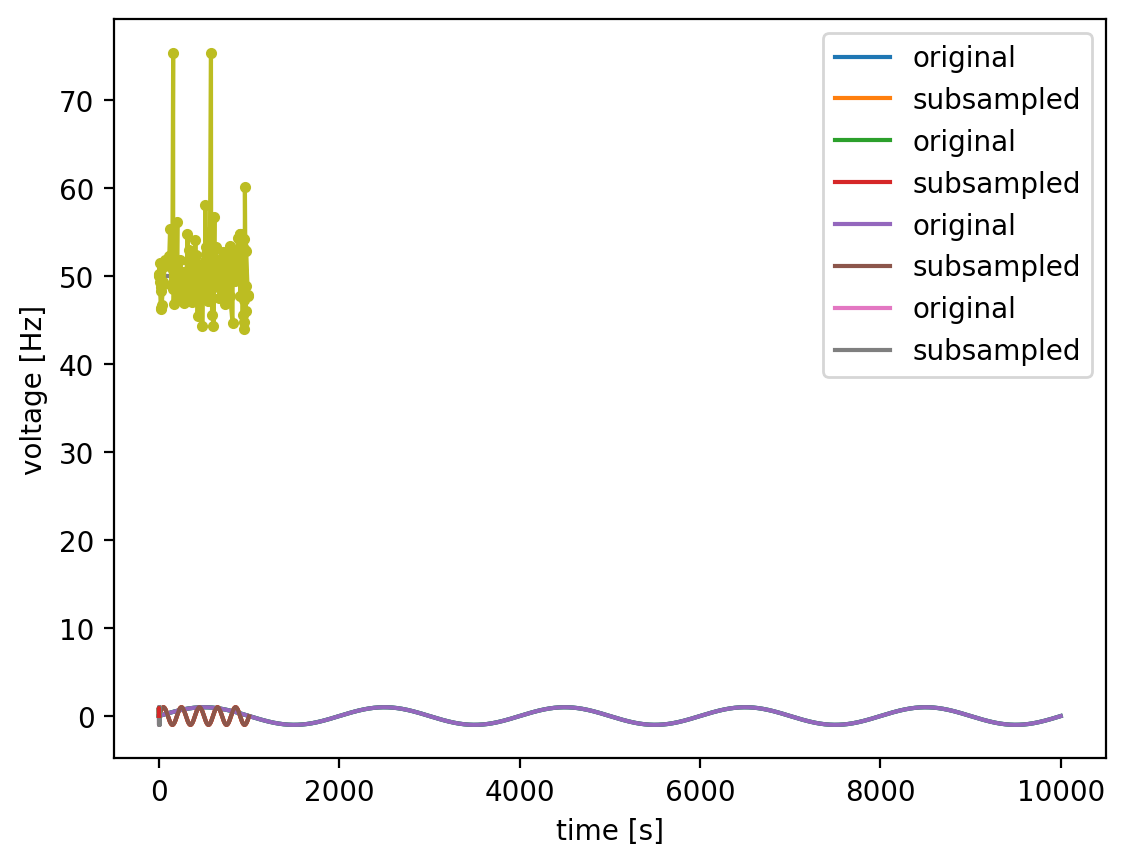

In [23]:
import nixio

# %config InlineBackend.figure_formats = ['retina'] # only for users with a high resolution display
import matplotlib.pyplot as plt
%matplotlib inline

nixfile = nixio.File.open("tagging1.nix", nixio.FileMode.ReadOnly)
block = nixfile.blocks[0]

stimulus_tag = block.tags["stimulus"]
stimulus_response_data = stimulus_tag.tagged_data("response")[:]
time = stimulus_tag.references["response"].dimensions[0].axis(len(stimulus_response_data), start_position=stimulus_tag.position[0])

plt.plot(time, stimulus_response_data)
plt.show()
nixfile.close()

**Tags** work in the unit of the data, respectively its dimension. It is, however, possible to provide diverging units to the **Tag**.

```
    # *********  This is the interesting part **********
    data = block.create_data_array("response", "nix.sampled", data=response, label="voltage", unit="mV")
    data.append_sampled_dimension(interval, label="time", unit="s")  # dimension is defined in seconds

    stim_tag = block.create_tag("stimulus", "nix.stimulus_segment", position=[stim_on * 1000])
    stim_tag.extent = [(stim_off - stim_on) * 1000]
    stim_tag.units = ["ms"]  # the tag is specified in milli seconds
    stim_tag.references.append(data)
    # **************************************************
```

Retrieving the tagged data works regardless. Units are scaled and handled transparently by the library. 

**Note:** This works only for SI units.

## Data and Metadata (data annotation)

### What are metadata and why are they needed?

With NIX, metadata can be stored alongside the data it belongs to.

The process of collecting the metadata can be automatized and the results are machine readable and can be searched programatically.

## Data and data annotation in the same NIX file

The entities of the NIX data model that were discussed so far carry enough information to get sufficient knowledge to understand the stored data (dimensions, units, labels). Often much more information than that is required to fully interpret the underlying experiment.

NIX does not only allow to save initial data and analysed data within the same file. It also allows to create structured annotations of the experiments that were conducted and connects this information directly with the data.

Metadata in NIX files is stored in the [odML format](https://g-node.github.io/python-odml):
- odML is a hierarchically structured data format that provides grouping in nestable `Sections`.
- `Sections` can hold both `Sections` and `Properties`.
- metadata information is stored in `Property`-`Value` pairs.
- `Sections` are the main structural elements, while `Properties` hold the actual metadata information.

### The odml data model in NIX
![](./resources/D1S3/nix_odML_model_simplified.png)

 On a conceptual level, data and metadata in a NIX file live side by side in parallel trees. The different layers can be connected from the data tree to the metadata tree. Corresponding data can be retrieved when exploring the metadata tree.

    --------------- NIX File --------
    ├─ Section              <---     ├─ Block
    |  ├─ Section                    |  ├─ DataArray
    |  |  └─ Property                |  ├─ DataArray
    |  └─ Section                    |  ├─ Tag
    |     └─ Property                |  └─ Multitag
    └─ Section              <---     └─ Block
       └─ Section           <---        ├─ DataArray
          ├─ Property                   ├─ DataArray
          ├─ Property                   └─ Group
          └─ Property                    


# Storing metadata in NIX

## Metadata basics: creating Section-Property trees and navigation

To introduce the usage of metadata functions in NIX, we'll keep it simple and abstract for now.

In [19]:
import nixio


In [20]:
# Lets explore the metadata functions of NIX before going more into detail
# We will re-use this file throughout the following examples
f = nixio.File.open("metadata.nix", nixio.FileMode.Overwrite)


In [21]:
# As expected there are no metadata in our current file yet.
print(f.sections)


[]


In [22]:
# First we need to create a Section that can hold our annotations. 
# We'll use abstract names and types for now.
sec = f.create_section(name="recording.20210405", 
                       type_="raw.data.recording")

f.sections


[Section: {name = recording.20210405, type = raw.data.recording}]

In [23]:
# Sections can hold further multiple Sections as well as 
# multiple Properties.
sec.sections


[]

In [24]:
# The section currently does not contain any Properties.
sec.props

[]

In [25]:
# We want to add information about a subject that was used in the 
# experiment.
sub_sec = sec.create_section(name="subject", 
                             type_="raw.data.recording")


In [26]:
# We'll add metadata about subjectID, subject species and 
# subject age as Properties to the "Subject" section.
_ = sub_sec.create_property(name="subjectID", 
                            values_or_dtype="78376446-f096-47b9-8bfe-ce1eb43a48dc")

_ = sub_sec.create_property(name="species", 
                            values_or_dtype="Mus Musculus")

# To fully describe metadata, properties support saving "unit" 
# and "uncertainty" together with values.
prop = sub_sec.create_property(name="age", 
                               values_or_dtype="4")

prop.unit = "weeks"
# prop.uncertainty

In [27]:
# Lets check what we have so far at the root of the file.
f.sections


[Section: {name = recording.20210405, type = raw.data.recording}]

In [28]:
# File and Sections also support the "pprint" function to make it easier 
# to get an overview of the contents of the metadata tree.
f.pprint()

File: name = metadata.nix
  recording.20210405 [raw.data.recording]
    subject [raw.data.recording]
        |- subjectID: ('78376446-f096-47b9-8bfe-ce1eb43a48dc',)
        |- species: ('Mus Musculus',)
        |- age: ('4',)weeks


In [29]:
# We access all Properties of the subsection containing subject related 
# information.
# Sections can be accessed via index or via name
f.sections[0].sections['subject'].props


[Property: {name = subjectID}, Property: {name = species}, Property: {name = age}]

In [30]:
# We can also again use the pprint function
f.sections[0].sections['subject'].pprint()

subject [raw.data.recording]
    |- subjectID: ('78376446-f096-47b9-8bfe-ce1eb43a48dc',)
    |- species: ('Mus Musculus',)
    |- age: ('4',)weeks


In [31]:
f.close()

## Connecting data and metadata

Until now we have seen how to create and store metadata in NIX files. Now we can check how to connect them to actual data.

In [32]:
f = nixio.File.open("metadata.nix", nixio.FileMode.ReadWrite)

We'll add some minimal abstract data

In [33]:
rec_block = f.create_block(name="project.recordings", 
                           type_="example.raw.data")

In [34]:
example_data_01 = [2, 2, 2, 6, 6, 6, 6, 2, 2, 2]
da = rec_block.create_data_array(name="recording.20210405", 
                                 array_type="shift.data", 
                                 data=example_data_01,
                                 label="df/f")

da.append_sampled_dimension(0.001, label="time", unit="s")

SampledDimension: {index = 1}

In [35]:
example_data_02 = [2, 2, 2, 8, 8, 8, 8, 2, 2, 2]
da = rec_block.create_data_array(name="recording.20210505.01", 
                                 array_type="shift.data", 
                                 data=example_data_02,
                                 label="df/f")

da.append_sampled_dimension(0.001, label="time", unit="s")

SampledDimension: {index = 1}

We'll also create a NIX Tag, that will reference a specific region in the data. We create the Tag on the same Block as the DataArrays 
it should reference.

In [36]:

stim_on = 4
stim_off = 8

stimulus_tag = rec_block.create_tag("stimulus.down.3", 
                                    "stimulus.shift", 
                                    position=[stim_on])

stimulus_tag.extent = [stim_off - stim_on]

stimulus_tag.references.append(
    f.blocks["project.recordings"].data_arrays["recording.20210405"])
stimulus_tag.references.append(
    f.blocks["project.recordings"].data_arrays["recording.20210505.01"])

Now we want to hook up the DataArrays and the Tag to more information via the metadata we have defined before. We will only reference the appropriate metadata for recording 20210405, since we have not defined metadata for the second recording yet. We'll set the metadata for both data array and tag

In [37]:
f.blocks["project.recordings"].data_arrays["recording.20210405"].metadata = \
    f.sections["recording.20210405"]
f.blocks["project.recordings"].tags["stimulus.down.3"].metadata = \
    f.sections["recording.20210405"]


We can now access the metadata from DataArray and Tag.

In [38]:
f.blocks["project.recordings"].data_arrays["recording.20210405"].metadata.pprint()


recording.20210405 [raw.data.recording]
  subject [raw.data.recording]
      |- subjectID: ('78376446-f096-47b9-8bfe-ce1eb43a48dc',)
      |- species: ('Mus Musculus',)
      |- age: ('4',)weeks


In [39]:
f.blocks["project.recordings"].tags["stimulus.down.3"].metadata.pprint()


recording.20210405 [raw.data.recording]
  subject [raw.data.recording]
      |- subjectID: ('78376446-f096-47b9-8bfe-ce1eb43a48dc',)
      |- species: ('Mus Musculus',)
      |- age: ('4',)weeks
